In [1]:
import pandas as pd
import numpy as np
from intervaltree import IntervalTree
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import os

In [2]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


In [3]:
def load_and_process_data(peaks_file: str, dexseq_file: str, padj_threshold: float = 0.05) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load and process the peaks and DEXSeq data files.
    
    Args:
        peaks_file: Path to peaks CSV file
        dexseq_file: Path to DEXSeq results CSV file
        padj_threshold: Adjusted p-value threshold for significance
    
    Returns:
        Tuple of processed peaks and DEXSeq DataFrames
    """
    # Load data
    peaks_df = pd.read_csv(peaks_file)
    dexseq_df = pd.read_csv(dexseq_file)
    
    # Filter significant DEXSeq results
    dexseq_df = dexseq_df[dexseq_df['padj'] < padj_threshold].copy()
    
    return peaks_df, dexseq_df

In [4]:

def create_interval_tree(peaks_df: pd.DataFrame) -> IntervalTree:
    """
    Create an interval tree from peaks data for efficient overlap detection.
    """
    tree = IntervalTree()
    for _, row in peaks_df.iterrows():
        tree.addi(row['start'], row['end'], {
            'seqnames': row['seqnames'],
            'peak_id': row.name,
            'peak_name': row['peak_name']
        })
    return tree

In [5]:
def find_overlaps(dexseq_df: pd.DataFrame, peaks_tree: IntervalTree) -> List[dict]:
    """
    Find overlaps between DEXSeq exons and peaks.
    """
    overlaps = []
    
    for _, exon in dexseq_df.iterrows():
        chr_name = exon['genomicData.seqnames']
        start = exon['genomicData.start']
        end = exon['genomicData.end']
        
        # Find overlapping peaks
        overlapping = peaks_tree.overlap(start, end)
        
        for overlap in overlapping:
            if overlap.data['seqnames'] == chr_name:
                overlaps.append({
                    'exon_id': exon['featureID'],
                    'peak_id': overlap.data['peak_id'],
                    'peak_name': overlap.data['peak_name'],
                    'dexseq_name': exon['dexseq_name'],
                    'chromosome': chr_name,
                    'overlap_start': max(start, overlap.begin),
                    'overlap_end': min(end, overlap.end),
                    'overlap_length': min(end, overlap.end) - max(start, overlap.begin),
                    'exon_log2fc': exon['log2fold_treated_control'],
                    'exon_padj': exon['padj']
                })
    
    return overlaps

In [6]:
def plot_overlap_lengths(overlaps_df: pd.DataFrame, ax):
    """Plot distribution of overlap lengths."""
    sns.histplot(data=overlaps_df, x='overlap_length', bins=30, ax=ax)
    ax.set_title('Distribution of Overlap Lengths')
    ax.set_xlabel('Overlap Length (bp)')

def plot_fc_correlation(overlaps_df: pd.DataFrame, peaks_df: pd.DataFrame, ax):
    """Plot correlation between exon and peak fold changes."""
    peak_fc = peaks_df.loc[overlaps_df['peak_id']]['L2FC'].values
    sns.scatterplot(data=overlaps_df, x='exon_log2fc', y=peak_fc, ax=ax)
    ax.set_title('Exon Log2FC vs Peak Log2FC')
    ax.set_xlabel('Exon Log2FC')
    ax.set_ylabel('Peak Log2FC')
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

def plot_chromosome_distribution(overlaps_df: pd.DataFrame, ax):
    """Plot distribution of overlaps across chromosomes."""
    overlaps_df['chromosome'].value_counts().plot(kind='bar', ax=ax)
    ax.set_title('Overlaps by Chromosome')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Number of Overlaps')

def visualize_overlaps(overlaps_df: pd.DataFrame, peaks_df: pd.DataFrame, dexseq_df: pd.DataFrame):
    """
    Create visualizations for the overlap analysis.
    """
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # 1. Distribution of overlap lengths
    ax1 = fig.add_subplot(gs[0, 0])
    plot_overlap_lengths(overlaps_df, ax1)
    
    # 2. Scatter plot of exon log2FC vs peak fold change
    ax2 = fig.add_subplot(gs[0, 1])
    plot_fc_correlation(overlaps_df, peaks_df, ax2)
    
    # 3. Chromosome distribution of overlaps
    ax3 = fig.add_subplot(gs[1, 0])
    plot_chromosome_distribution(overlaps_df, ax3)
    
    plt.tight_layout()
    return fig

In [7]:
# Example usage
peaks_file = "./DATA/Peak.csv"
dexseq_file = "./output/dexseq_results_PW1_vs_combined_controls_cleaned_permisive.csv"
output_prefix = "./output/overlap_analysis"

# overlaps_df = main(peaks_file, dexseq_file, output_prefix)

In [8]:
# Load and process data
peaks_df, dexseq_df = load_and_process_data(peaks_file, dexseq_file)

In [9]:
pd.set_option('display.max_columns', None)
peaks_df.head()

,Row.names,seqnames,start,end,width,annotation,geneChr,geneStart,geneEnd,geneLength,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,ASE1,ASE2,GeneID,Ctrl.bam,V5.bam,difference,FC,L2FC
0,chr15:25051475-25051745,chr15,25051475.0,25051745.0,271.0,Promoter (<=1kb),15.0,25051477.0,25051571.0,95.0,100033413.0,ENST00000384335.1,0.0,ENSG00000207063,SNORD116-1,"small nucleolar RNA, C/D box 116-1",NaN,NaN,controlledV5_peak_329,0,961,961,961.0,9.908392621
1,chr2:74154059-74154316,chr2,74154059.0,74154316.0,258.0,3' UTR,2.0,74148079.0,74151952.0,3874.0,100507171.0,ENST00000656407.1,5980.0,ENSG00000225439,BOLA3-DT,BOLA3 divergent transcript,NaN,NaN,controlledV5_peak_575,0,31,31,31.0,4.95419631
2,chr17:21198291-21198758,chr17,21198291.0,21198758.0,468.0,3' UTR,17.0,21184385.0,21193265.0,8881.0,25979.0,ENST00000581463.1,13906.0,ENSG00000109016,DHRS7B,dehydrogenase/reductase 7B,NaN,NaN,controlledV5_peak_423,0,20,20,20.0,4.321928095
3,chr17:744815-745029,chr17,744815.0,745029.0,215.0,3' UTR,17.0,747844.0,752038.0,4195.0,50628.0,ENST00000574958.1,7009.0,ENSG00000179409,GEMIN4,gem nuclear organelle associated protein 4,NaN,NaN,controlledV5_peak_403,0,18,18,18.0,4.169925001
4,chr10:27134830-27135032,chr10,27134830.0,27135032.0,203.0,Promoter (1-2kb),10.0,27123547.0,27136337.0,12791.0,10730.0,ENST00000463270.1,1305.0,ENSG00000136758,YME1L1,YME1 like 1 ATPase,NaN,NaN,controlledV5_peak_142,0,17,17,17.0,4.087462841


In [10]:
peaks_df = peaks_df.rename(columns={"Row.names": "peak_name"})

In [11]:
print(list(peaks_df['seqnames'][:5]))
print(list(peaks_df.iloc[:5].index))

['chr15', 'chr2', 'chr17', 'chr17', 'chr10']
[0, 1, 2, 3, 4]


In [12]:
dexseq_df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.14:E001,ENSG00000000003.14,E001,120.179059,0.011335,2984.629607,0.000000e+00,0.000000e+00,16.638651,14.784409,-0.479628,chrX,100627109,100628669,1561,-,123,139,86,83,106,98,119,182,189
1,ENSG00000000003.14:E002,ENSG00000000003.14,E002,1270.531715,0.006461,396.260920,8.975001e-87,1.213046e-86,30.813401,30.602511,-0.045605,chrX,100628670,100629986,1317,-,1007,1237,687,906,1184,974,1419,2630,2220
2,ENSG00000000003.14:E003,ENSG00000000003.14,E003,444.716283,0.008585,1806.024855,0.000000e+00,0.000000e+00,23.933712,23.706313,-0.051117,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.14:E004,ENSG00000000003.14,E004,1.981576,0.022925,3109.695893,0.000000e+00,0.000000e+00,2.492781,2.656301,0.185495,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.14:E005,ENSG00000000003.14,E005,358.929210,0.007125,2538.819848,0.000000e+00,0.000000e+00,22.574929,22.337963,-0.053991,chrX,100632485,100632568,84,-,289,347,196,233,334,297,393,719,654


In [13]:
dexseq_df = dexseq_df.rename(columns={"Unnamed: 0": "dexseq_name"})

In [14]:
dexseq_df.columns

Index(['dexseq_name', 'groupID', 'featureID', 'exonBaseMean', 'dispersion',
       'stat', 'pvalue', 'padj', 'control', 'treated',
       'log2fold_treated_control', 'genomicData.seqnames', 'genomicData.start',
       'genomicData.end', 'genomicData.width', 'genomicData.strand',
       'countData.EDO_1', 'countData.EDO_2', 'countData.EDO_3',
       'countData.ND1_1', 'countData.ND1_2', 'countData.ND1_3',
       'countData.PW1_1', 'countData.PW1_2', 'countData.PW1_3'],
      dtype='object')

In [15]:
print(list(dexseq_df['genomicData.seqnames'][:5]))
print(list(dexseq_df['featureID'][:5]))


['chrX', 'chrX', 'chrX', 'chrX', 'chrX']
['E001', 'E002', 'E003', 'E004', 'E005']


In [16]:
# Create interval tree for efficient overlap detection
peaks_tree = create_interval_tree(peaks_df)

In [17]:
list(peaks_tree.items())[:10]



[Interval(44065741.0, 44065975.0, {'seqnames': 'chr2', 'peak_id': 691, 'peak_name': 'chr2:44065741-44065975'}),
 Interval(2431546.0, 2431734.0, {'seqnames': 'chr19', 'peak_id': 619, 'peak_name': 'chr19:2431546-2431734'}),
 Interval(75321808.0, 75322308.0, {'seqnames': 'chr15', 'peak_id': 1085, 'peak_name': 'chr15:75321808-75322308'}),
 Interval(253490.0, 253707.0, {'seqnames': 'chr10', 'peak_id': 37, 'peak_name': 'chr10:253490-253707'}),
 Interval(47783878.0, 47784227.0, {'seqnames': 'chr12', 'peak_id': 389, 'peak_name': 'chr12:47783878-47784227'}),
 Interval(41604043.0, 41604252.0, {'seqnames': 'chr22', 'peak_id': 785, 'peak_name': 'chr22:41604043-41604252'}),
 Interval(1787781.0, 1788035.0, {'seqnames': 'chr16', 'peak_id': 718, 'peak_name': 'chr16:1787781-1788035'}),
 Interval(19378387.0, 19378889.0, {'seqnames': 'chr9', 'peak_id': 1063, 'peak_name': 'chr9:19378387-19378889'}),
 Interval(37925659.0, 37925853.0, {'seqnames': 'chr22', 'peak_id': 449, 'peak_name': 'chr22:37925659-379258

In [18]:
# Find overlaps
overlaps = find_overlaps(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [19]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,overlap_start,overlap_end,overlap_length,exon_log2fc,exon_padj
0,E007,474,chr17:47132254-47132464,ENSG00000004897.12:E007,chr17,47132257.0,47132374.0,117.0,-0.094016,0.000000e+00
1,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,57428714.0,57428937.0,223.0,-0.207524,0.000000e+00
2,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,57428938.0,57428958.0,20.0,-0.248556,0.000000e+00
3,E011,160,chr7:107160282-107160602,ENSG00000005249.13:E011,chr7,107160282.0,107160602.0,320.0,-0.141606,4.551355e-23
4,E031,395,chr16:3850321-3850506,ENSG00000005339.14:E031,chr16,3850321.0,3850506.0,185.0,0.036842,7.307589e-206


In [20]:
overlaps_df.shape

(981, 10)

In [21]:
# Save overlaps to file
overlaps_df.to_csv(f"{output_prefix}_overlaps.csv", index=False)

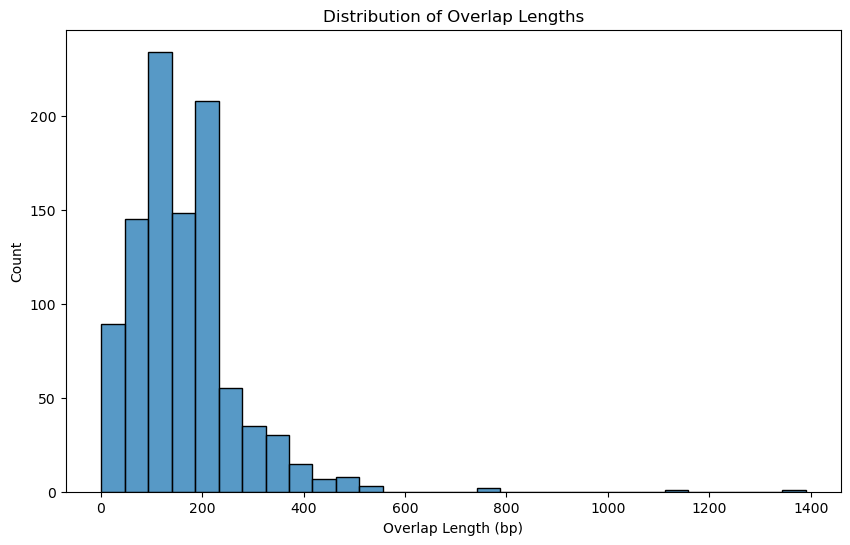

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_overlap_lengths(overlaps_df, ax)


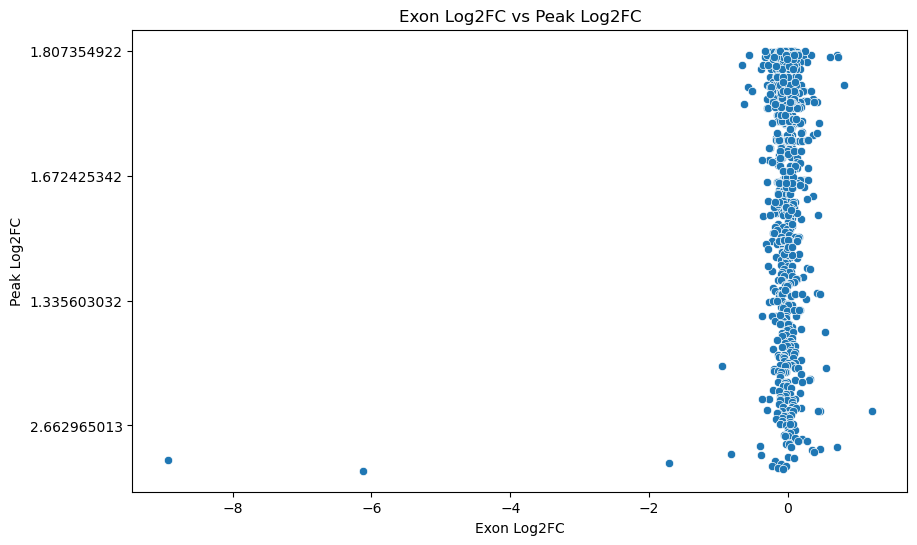

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_fc_correlation(overlaps_df, peaks_df, ax)

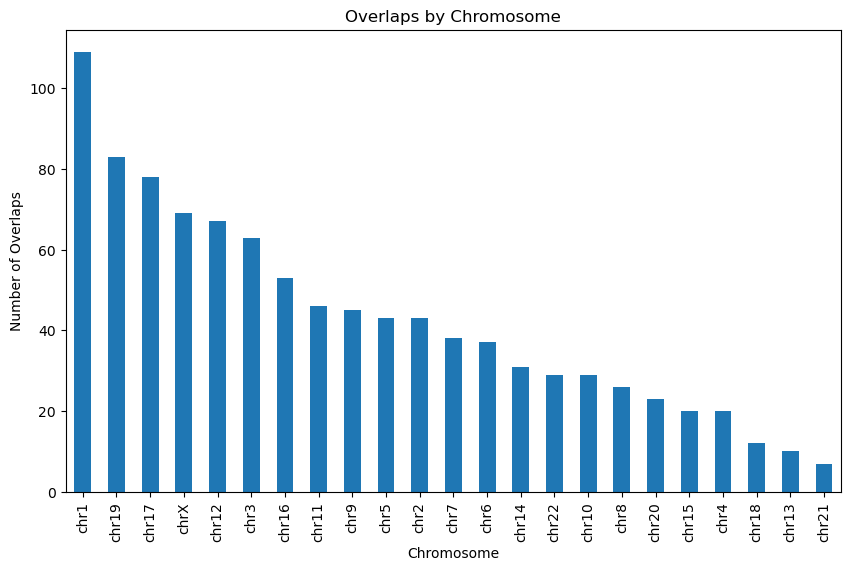

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_chromosome_distribution(overlaps_df, ax)

In [25]:
total_peaks = len(peaks_df)
total_exons = len(dexseq_df)
peaks_with_overlaps = len(overlaps_df['peak_id'].unique())
exons_with_overlaps = len(overlaps_df['exon_id'].unique())

print(f"Total Peaks: {total_peaks}")
print(f"Total Diff. Expressed Exons: {total_exons}")
print(f"Peaks with Overlaps: {peaks_with_overlaps}")
print(f"Exons with Overlaps: {exons_with_overlaps}")
print(f"Total Overlap Events: {len(overlaps_df)}")

Total Peaks: 1136
Total Diff. Expressed Exons: 247028
Peaks with Overlaps: 697
Exons with Overlaps: 67
Total Overlap Events: 981


In [26]:
def find_overlaps2(dexseq_df: pd.DataFrame, peaks_tree: IntervalTree) -> List[dict]:
    """
    Find overlaps and nearby peaks for DEXSeq exons.
    Also calculates distance to nearest peak for non-overlapping cases.
    """
    results = []
    
    for index, exon in dexseq_df.iterrows():
        chr_name = exon['genomicData.seqnames']
        exon_start = exon['genomicData.start']
        exon_end = exon['genomicData.end']
        exon_center = (exon_start + exon_end) / 2
        
        # Extend search window by 10kb in each direction
        search_start = exon_start - 10000
        search_end = exon_end + 10000
        
        # Find peaks in extended window
        nearby = peaks_tree.overlap(search_start, search_end)
        if index == 0 and len(nearby) > 0:
            print(list(nearby))
        
        for peak in nearby:
            if peak.data['seqnames'] == chr_name:
                peak_center = (peak.begin + peak.end) / 2
                
                # Calculate distance (negative if peak is upstream, positive if downstream)
                distance = peak_center - exon_center
                
                # Calculate overlap (if any)
                overlap_start = max(exon_start, peak.begin)
                overlap_end = min(exon_end, peak.end)
                overlap_length = max(0, overlap_end - overlap_start)
                
                results.append({
                    'exon_id': exon['featureID'],
                    'peak_id': peak.data['peak_id'],
                    'peak_name': peak.data['peak_name'],
                    'dexseq_name': exon['dexseq_name'],
                    'chromosome': chr_name,
                    'distance_to_peak': distance,
                    'overlap_length': overlap_length,
                    'exon_log2fc': exon['log2fold_treated_control'],
                    'exon_padj': exon['padj']
                })
    
    return results

def plot_distance_vs_fc(overlaps_df: pd.DataFrame, ax):
    """Plot relationship between peak distance and exon fold change."""
    # Convert distance to kb for better visualization
    overlaps_df['distance_kb'] = overlaps_df['distance_to_peak'] / 1000
    
    # Create scatter plot
    sns.scatterplot(
        data=overlaps_df,
        x='distance_kb',
        y='exon_log2fc',
        alpha=0.5,
        ax=ax
    )
    
    # Add trend line
    sns.regplot(
        data=overlaps_df,
        x='distance_kb',
        y='exon_log2fc',
        scatter=False,
        color='red',
        ax=ax
    )
    
    ax.set_title('Exon Log2FC vs Distance to Peak')
    ax.set_xlabel('Distance to Peak (kb)')
    ax.set_ylabel('Exon Log2FC')
    
    # Add vertical line at x=0 to mark the exon position
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add horizontal line at y=0 to mark no change in expression
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

def visualize_distance_analysis(overlaps_df: pd.DataFrame):
    """
    Create visualizations for the distance analysis.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Distance vs Fold Change scatter plot
    plot_distance_vs_fc(overlaps_df, ax1)
    
    # 2. Distribution of distances
    sns.histplot(
        data=overlaps_df,
        x='distance_to_peak',
        bins=50,
        ax=ax2
    )
    ax2.set_title('Distribution of Peak Distances')
    ax2.set_xlabel('Distance to Peak (bp)')
    
    plt.tight_layout()
    return fig

In [27]:
# # Find overlaps and distances
overlaps = find_overlaps2(dexseq_df, peaks_tree)
overlaps_df = pd.DataFrame(overlaps)

In [28]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj
0,E001,641,chr2:37222376-37222562,ENSG00000003509.16:E001,chr2,-9199.0,0.0,-0.042174,0.0
1,E002,641,chr2:37222376-37222562,ENSG00000003509.16:E002,chr2,-9250.5,0.0,0.121151,0.0
2,E003,641,chr2:37222376-37222562,ENSG00000003509.16:E003,chr2,-9717.0,0.0,0.211989,0.0
3,E004,474,chr17:47132254-47132464,ENSG00000004897.12:E004,chr17,9837.0,0.0,-0.079177,0.0
4,E005,474,chr17:47132254-47132464,ENSG00000004897.12:E005,chr17,8436.0,0.0,-0.102252,0.0


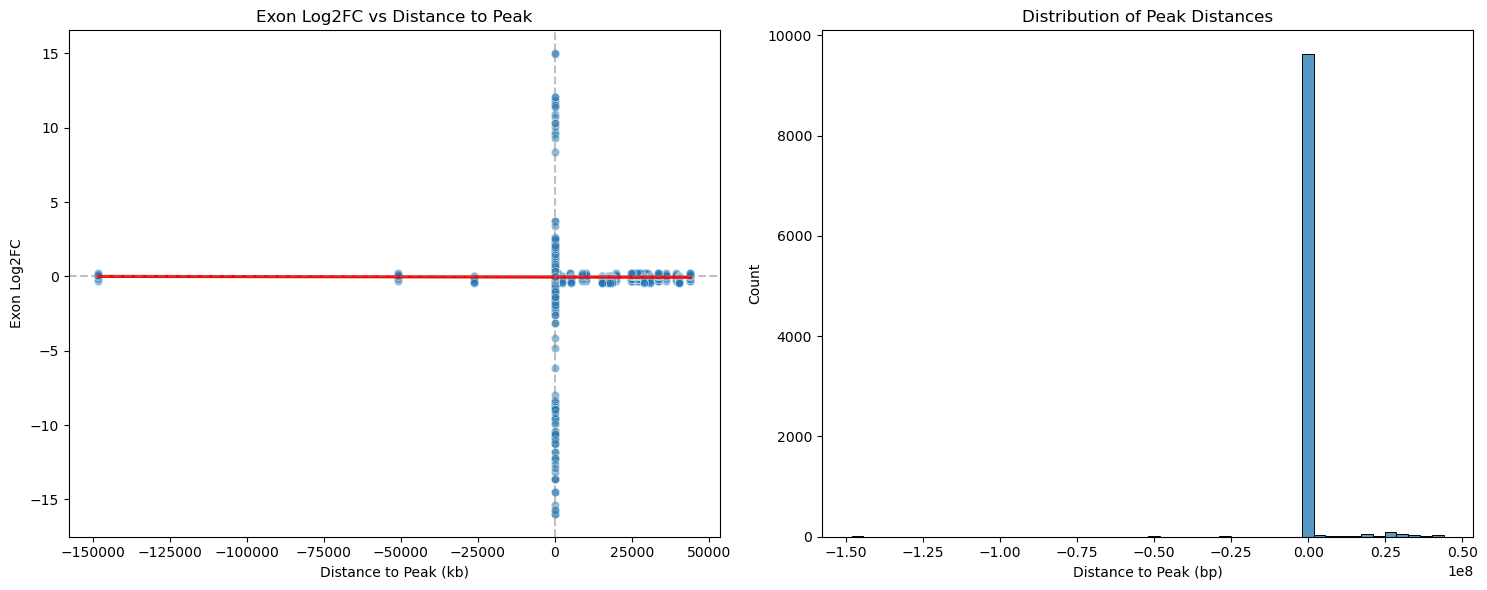

In [29]:
# Create visualization
fig = visualize_distance_analysis(overlaps_df)
plt.show()

# Complementarity analysis

In [75]:
ASE1 = 'AACATTCCTTGGAAAAG'
ASE2 = 'CGTCATTCTCATCGGAA'

cASE1 = 'CTTTTCCAAGGAATGTT'
cASE2 = 'TTCCGATGAGAATGACG'

In [82]:
%%script false --no-raise-error
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner
import requests
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

def get_exon_sequence(chromosome: str, start: int, end: int) -> str:
    """
    Fetch genomic sequence for given coordinates using Ensembl REST API.
    """
    server = "https://rest.ensembl.org"
    ext = f"/sequence/region/human/{chromosome}:{start}..{end}:1?"
    
    r = requests.get(server + ext, headers={"Content-Type": "text/plain"})
    if r.ok:
        return r.text
    return None

def analyze_als_complementarity(row: pd.Series, dexseq_df: pd.DataFrame, 
                              als1: str = 'CTTTTCCAAGGAATGTT', 
                              als2: str = 'TTCCGATGAGAATGACG') -> dict:
    """
    Analyze ALS complementarity for an exon and its neighbors using local alignment.
    """
    print(f"Analyzing exon {row['exon_id']} from gene {row['dexseq_name'].split(':')[0]}")
    
    # Get current exon info
    current_gene = row['dexseq_name'].split(':')[0]
    current_exon_num = int(row['exon_id'].replace('E', ''))
    
    # Find neighboring exons from the same gene
    gene_exons = dexseq_df[dexseq_df['dexseq_name'].str.startswith(current_gene)].copy()
    gene_exons['exon_num'] = gene_exons['featureID'].str.replace('E', '').astype(int)
    gene_exons = gene_exons.sort_values('exon_num')
    
    # Get sequences for current and neighboring exons
    sequences = {}
    for idx, exon in gene_exons.iterrows():
        if abs(exon['exon_num'] - current_exon_num) <= 1:  # Current and immediate neighbors
            seq = get_exon_sequence(
                exon['genomicData.seqnames'],
                exon['genomicData.start'],
                exon['genomicData.end']
            )
            if seq:
                sequences[exon['featureID']] = seq.strip()

    def align_sequence(query, target):
        """Perform local alignment and return the best score."""
        aligner = PairwiseAligner()
        aligner.mode = 'local'
        aligner.match_score = 1
        aligner.mismatch_score = -1
        aligner.open_gap_score = -100
        aligner.extend_gap_score = -100
        try:
            alignments = aligner.align(query, target)
            best_alignment = max(alignments, key=lambda a: a.score)
            return {"score": best_alignment.score, "alignment": best_alignment}
        except Exception as e:
            print(f"Error during alignment: {str(e)}")
            return {"score": 0, "alignment": None}
    
    results = {}
    for exon_id, seq in sequences.items():
        try:
            # Convert sequences to Seq objects - only forward sequence
            forward_seq = Seq(seq.upper())
            als1_seq = Seq(als1.upper())
            als2_seq = Seq(als2.upper())
            
            # Align with ALS1 - only forward alignment
            forward_als1 = align_sequence(forward_seq, als1_seq)
            best_als1 = forward_als1
            
            # Align with ALS2 - only forward alignment
            forward_als2 = align_sequence(forward_seq, als2_seq)
            best_als2 = forward_als2
            
            results[exon_id] = {
                'als1_score': best_als1["score"],
                'als2_score': best_als2["score"],
                'als1_alignment': str(best_als1["alignment"]) if best_als1["alignment"] else "",
                'als2_alignment': str(best_als2["alignment"]) if best_als2["alignment"] else "",
                'sequence': seq
            }
            
        except Exception as e:
            print(f"Error processing sequence for exon {exon_id}: {str(e)}")
            results[exon_id] = {
                'als1_score': 0,
                'als2_score': 0,
                'als1_alignment': "",
                'als2_alignment': "",
                'sequence': seq
            }
    
    return results

def process_chunk(chunk_data):
    """
    Process a chunk of overlaps data in parallel
    """
    chunk, dexseq_df = chunk_data
    print(f"Processing chunk of size {len(chunk)}")
    results = []
    
    for idx, row in chunk.iterrows():
        try:
            als_analysis = analyze_als_complementarity(row, dexseq_df)
            
            # Prepare the result dictionary
            row_dict = row.to_dict()
            
            # Add ALS scores if available
            if als_analysis and row['exon_id'] in als_analysis:
                result = als_analysis[row['exon_id']]
                row_dict.update({
                    'current_exon_als1_score': result['als1_score'],
                    'current_exon_als2_score': result['als2_score'],
                    'neighboring_exons_analysis': als_analysis
                })
            else:
                row_dict.update({
                    'current_exon_als1_score': 0,
                    'current_exon_als2_score': 0,
                    'neighboring_exons_analysis': {}
                })
            
            results.append(row_dict)
            
        except Exception as e:
            print(f"Error processing row with exon {row['exon_id']}: {str(e)}")
            row_dict = row.to_dict()
            row_dict.update({
                'current_exon_als1_score': 0,
                'current_exon_als2_score': 0,
                'neighboring_exons_analysis': {}
            })
            results.append(row_dict)
    
    print(f"Completed chunk processing with {len(results)} results")
    return results


def analyze_overlaps_with_als(overlaps_df: pd.DataFrame, dexseq_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze ALS complementarity for all overlapping exons and their neighbors using parallel processing.
    """
    print("Starting ALS complementarity analysis...")
    
    # Determine number of cores to use (leave one free for system)
    n_cores = multiprocessing.cpu_count() - 1
    print(f"Using {n_cores} CPU cores for parallel processing")
    
    # Split the dataframe into chunks
    chunk_size = len(overlaps_df) // n_cores
    if chunk_size == 0:
        chunk_size = 1
    chunks = [overlaps_df.iloc[i:i + chunk_size] for i in range(0, len(overlaps_df), chunk_size)]
    print(f"Split data into {len(chunks)} chunks of approximately {chunk_size} rows each")
    
    # Prepare data for parallel processing
    chunk_data = [(chunk, dexseq_df) for chunk in chunks]
    
    # Process chunks in parallel
    all_results = []
    print("Starting parallel processing...")
    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        chunk_results = list(executor.map(process_chunk, chunk_data))
        for results in chunk_results:
            all_results.extend(results)
    
    print(f"Analysis complete. Processed {len(all_results)} total entries")
    return pd.DataFrame(all_results)

# After running the analysis:
enriched_overlaps_df = analyze_overlaps_with_als(overlaps_df, dexseq_df)

Starting ALS complementarity analysis...
Using 71 CPU cores for parallel processing
Split data into 72 chunks of approximately 141 rows each
Starting parallel processing...


Processing chunk of size 141
Analyzing exon E001 from gene ENSG00000003509.16
Processing chunk of size 141
Analyzing exon E030 from gene ENSG00000010292.13
Processing chunk of size 141
Analyzing exon E007 from gene ENSG00000026025.16
Analyzing exon E002 from gene ENSG00000003509.16
Processing chunk of size 141
Analyzing exon E001 from gene ENSG00000060688.13
Processing chunk of size 141
Analyzing exon E026 from gene ENSG00000065150.20
Processing chunk of size 141
Analyzing exon E014 from gene ENSG00000071127.17
Analyzing exon E003 from gene ENSG00000003509.16
Analyzing exon E008 from gene ENSG00000026025.16
Analyzing exon E002 from gene ENSG00000060688.13
Processing chunk of size 141
Analyzing exon E007 from gene ENSG00000077549.18
Analyzing exon E027 from gene ENSG00000065150.20
Processing chunk of size 141
Analyzing exon E002 from gene ENSG00000084623.11
Analyzing exon E031 from gene ENSG00000010292.13
Analyzing exon E015 from gene ENSG00000071127.17
Processing chunk of size 141
Anal

In [88]:
# %%script false --no-raise-error
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner
import requests
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import pandas as pd
from typing import Dict, Optional, Any
import time

def get_exon_sequence(chromosome: str, start: int, end: int) -> Optional[str]:
    """
    Fetch genomic sequence for given coordinates using Ensembl REST API.
    Includes retry logic and better error handling.
    """
    server = "https://rest.ensembl.org"
    ext = f"/sequence/region/human/{chromosome}:{start}..{end}:1?"
    max_retries = 3
    
    for attempt in range(max_retries):
        try:
            r = requests.get(server + ext, 
                           headers={"Content-Type": "text/plain"},
                           timeout=30)  # Add timeout
            if r.ok:
                sequence = r.text.strip()
                if sequence:  # Check if sequence is not empty
                    return sequence
            time.sleep(1)  # Add delay between retries
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {chromosome}:{start}-{end}, attempt {attempt + 1}: {str(e)}")
            if attempt == max_retries - 1:
                print(f"Failed to fetch sequence after {max_retries} attempts")
    return None

def align_sequence(query: Seq, target: Seq) -> Dict[str, Any]:
    """
    Perform local alignment and return the best score and alignment.
    Added input validation and better error handling.
    """
    if not query or not target:
        return {"score": 0, "alignment": None}
        
    aligner = PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 1
    aligner.mismatch_score = -1
    aligner.open_gap_score = -100
    aligner.extend_gap_score = -100
    
    try:
        alignments = list(aligner.align(query, target))  # Convert iterator to list
        if alignments:
            best_alignment = max(alignments, key=lambda a: a.score)
            return {"score": best_alignment.score, "alignment": best_alignment}
        return {"score": 0, "alignment": None}
    except Exception as e:
        print(f"Error during alignment: {str(e)}")
        return {"score": 0, "alignment": None}

def analyze_als_complementarity(row: pd.Series, dexseq_df: pd.DataFrame, 
                              als1: str = 'CTTTTCCAAGGAATGTT', 
                              als2: str = 'TTCCGATGAGAATGACG') -> dict:
    """
    Analyze ALS complementarity for an exon and its neighbors using local alignment.
    Added input validation and better sequence handling.
    """
    if not isinstance(row, pd.Series) or not isinstance(dexseq_df, pd.DataFrame):
        print("Invalid input types")
        return {}
        
    try:
        # print(f"Analyzing exon {row['exon_id']} from gene {row['dexseq_name'].split(':')[0]}")
        
        # Get current exon info
        current_gene = row['dexseq_name'].split(':')[0]
        current_exon_num = int(row['exon_id'].replace('E', ''))
        
        # Find neighboring exons from the same gene
        gene_exons = dexseq_df[dexseq_df['dexseq_name'].str.startswith(current_gene)].copy()
        if gene_exons.empty:
            print(f"No exons found for gene {current_gene}")
            return {}
            
        gene_exons['exon_num'] = gene_exons['featureID'].str.replace('E', '').astype(int)
        gene_exons = gene_exons.sort_values('exon_num')
        
        # Get sequences for current and neighboring exons
        sequences = {}
        for idx, exon in gene_exons.iterrows():
            if abs(exon['exon_num'] - current_exon_num) <= 1:
                seq = get_exon_sequence(
                    str(exon['genomicData.seqnames']),  # Ensure string type
                    int(exon['genomicData.start']),     # Ensure int type
                    int(exon['genomicData.end'])        # Ensure int type
                )
                if seq:
                    sequences[exon['featureID']] = seq.strip().upper()  # Normalize sequence
        
        if not sequences:
            print(f"No valid sequences found for exon {row['exon_id']}")
            return {}
        
        results = {}
        for exon_id, seq in sequences.items():
            try:
                # Convert sequences to Seq objects with validation
                try:
                    forward_seq = Seq(seq)
                    als1_seq = Seq(als1.upper())
                    als2_seq = Seq(als2.upper())
                except ValueError as e:
                    print(f"Invalid sequence for exon {exon_id}: {str(e)}")
                    continue
                
                # Align with ALS1
                forward_als1 = align_sequence(forward_seq, als1_seq)
                best_als1 = forward_als1
                
                # Align with ALS2
                forward_als2 = align_sequence(forward_seq, als2_seq)
                best_als2 = forward_als2
                
                results[exon_id] = {
                    'als1_score': float(best_als1["score"]),  # Ensure float type
                    'als2_score': float(best_als2["score"]),  # Ensure float type
                    'als1_alignment': str(best_als1["alignment"]) if best_als1["alignment"] else "",
                    'als2_alignment': str(best_als2["alignment"]) if best_als2["alignment"] else "",
                    'sequence': seq,
                    'sequence_length': len(seq)  # Add sequence length for validation
                }
                
            except Exception as e:
                print(f"Error processing sequence for exon {exon_id}: {str(e)}")
                continue
                
        return results
        
    except Exception as e:
        print(f"Error in analyze_als_complementarity: {str(e)}")
        return {}

def process_chunk(chunk_data: tuple) -> list:
    """
    Process a chunk of overlaps data in parallel with enhanced error handling.
    """
    try:
        chunk, dexseq_df = chunk_data
        print(f"Processing chunk of size {len(chunk)}")
        results = []
        
        for idx, row in chunk.iterrows():
            try:
                als_analysis = analyze_als_complementarity(row, dexseq_df)
                
                # Prepare the result dictionary
                row_dict = row.to_dict()
                
                # Add ALS scores if available
                if als_analysis and row['exon_id'] in als_analysis:
                    result = als_analysis[row['exon_id']]
                    row_dict.update({
                        'current_exon_als1_score': result['als1_score'],
                        'current_exon_als2_score': result['als2_score'],
                        'neighboring_exons_analysis': als_analysis
                    })
                else:
                    row_dict.update({
                        'current_exon_als1_score': 0.0,  # Consistent float type
                        'current_exon_als2_score': 0.0,  # Consistent float type
                        'neighboring_exons_analysis': {}
                    })
                
                results.append(row_dict)
                
            except Exception as e:
                print(f"Error processing row with exon {row['exon_id']}: {str(e)}")
                row_dict = row.to_dict()
                row_dict.update({
                    'current_exon_als1_score': 0.0,
                    'current_exon_als2_score': 0.0,
                    'neighboring_exons_analysis': {}
                })
                results.append(row_dict)
        
        print(f"Completed chunk processing with {len(results)} results")
        return results
        
    except Exception as e:
        print(f"Error in process_chunk: {str(e)}")
        return []

def analyze_overlaps_with_als(overlaps_df: pd.DataFrame, dexseq_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze ALS complementarity for all overlapping exons and their neighbors using parallel processing.
    Added input validation and better error handling.
    """
    if overlaps_df.empty or dexseq_df.empty:
        print("Empty input DataFrame(s)")
        return pd.DataFrame()
        
    try:
        print("Starting ALS complementarity analysis...")
        
        # Determine number of cores to use (leave one free for system)
        n_cores = max(1, multiprocessing.cpu_count() - 1)
        print(f"Using {n_cores} CPU cores for parallel processing")
        
        # Split the dataframe into chunks
        chunk_size = max(1, len(overlaps_df) // n_cores)
        chunks = [overlaps_df.iloc[i:i + chunk_size] for i in range(0, len(overlaps_df), chunk_size)]
        print(f"Split data into {len(chunks)} chunks of approximately {chunk_size} rows each")
        
        # Prepare data for parallel processing
        chunk_data = [(chunk, dexseq_df) for chunk in chunks]
        
        # Process chunks in parallel with timeout
        all_results = []
        print("Starting parallel processing...")
        with ProcessPoolExecutor(max_workers=n_cores) as executor:
            chunk_results = list(executor.map(process_chunk, chunk_data, timeout=3600))  # 1 hour timeout
            for results in chunk_results:
                if results:  # Check if results is not empty
                    all_results.extend(results)
        
        if not all_results:
            print("No results generated from analysis")
            return pd.DataFrame()
            
        print(f"Analysis complete. Processed {len(all_results)} total entries")
        return pd.DataFrame(all_results)
        
    except Exception as e:
        print(f"Error in analyze_overlaps_with_als: {str(e)}")
        return pd.DataFrame()
    
# After running the analysis:
enriched_overlaps_df2 = analyze_overlaps_with_als(overlaps_df, dexseq_df)

Starting ALS complementarity analysis...
Using 71 CPU cores for parallel processing
Split data into 72 chunks of approximately 141 rows each
Starting parallel processing...


Processing chunk of size 141
Analyzing exon E001 from gene ENSG00000003509.16
Processing chunk of size 141
Analyzing exon E030 from gene ENSG00000010292.13
Processing chunk of size 141
Analyzing exon E007 from gene ENSG00000026025.16
Processing chunk of size 141
Analyzing exon E001 from gene ENSG00000060688.13
Processing chunk of size 141
Analyzing exon E026 from gene ENSG00000065150.20
Processing chunk of size 141
Analyzing exon E014 from gene ENSG00000071127.17
Analyzing exon E008 from gene ENSG00000026025.16
Analyzing exon E002 from gene ENSG00000003509.16
Analyzing exon E002 from gene ENSG00000060688.13
Processing chunk of size 141
Analyzing exon E007 from gene ENSG00000077549.18
Analyzing exon E027 from gene ENSG00000065150.20
Processing chunk of size 141
Analyzing exon E002 from gene ENSG00000084623.11
Processing chunk of size 141
Analyzing exon E007 from gene ENSG00000088340.16
Processing chunk of size 141
Analyzing exon E001 from gene ENSG00000090621.14
Processing chunk of size

In [105]:
# Load the enriched overlaps dataframe from CSV
enriched_overlaps_df = pd.read_csv('enriched_overlaps_results.csv')

# Convert the string representation of dictionary back to dictionary
enriched_overlaps_df['neighboring_exons_analysis'] = enriched_overlaps_df['neighboring_exons_analysis'].apply(eval)

print("Loaded enriched overlaps results from enriched_overlaps_results.csv")

Loaded enriched overlaps results from enriched_overlaps_results.csv


In [106]:
# Load the enriched overlaps dataframe from CSV
enriched_overlaps_df2 = pd.read_csv('enriched_overlaps_results2.csv')

# Convert the string representation of dictionary back to dictionary
enriched_overlaps_df2['neighboring_exons_analysis'] = enriched_overlaps_df2['neighboring_exons_analysis'].apply(eval)

print("Loaded enriched overlaps results from enriched_overlaps_results2.csv")

Loaded enriched overlaps results from enriched_overlaps_results2.csv


In [92]:
# # Save the enriched overlaps dataframe to a CSV file
# enriched_overlaps_df.to_csv('enriched_overlaps_results.csv', index=False)
# print("Saved enriched overlaps results to enriched_overlaps_results.csv")

Saved enriched overlaps results to enriched_overlaps_results.csv


In [91]:
# # Save the enriched overlaps dataframe to a CSV file
# enriched_overlaps_df2.to_csv('enriched_overlaps_results2.csv', index=False)
# print("Saved enriched overlaps results to enriched_overlaps_results2.csv")

Saved enriched overlaps results to enriched_overlaps_results2.csv


In [ ]:
enriched_overlaps_df.head()

In [89]:
enriched_overlaps_df2.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_als1_score,current_exon_als2_score,neighboring_exons_analysis
0,E001,641,chr2:37222376-37222562,ENSG00000003509.16:E001,chr2,-9199.0,0.0,-0.042174,0.0,-9.1990,4.0,3.0,"{'E001': {'als1_score': 4.0, 'als2_score': 3.0..."
1,E002,641,chr2:37222376-37222562,ENSG00000003509.16:E002,chr2,-9250.5,0.0,0.121151,0.0,-9.2505,4.0,5.0,"{'E001': {'als1_score': 4.0, 'als2_score': 3.0..."
2,E003,641,chr2:37222376-37222562,ENSG00000003509.16:E003,chr2,-9717.0,0.0,0.211989,0.0,-9.7170,0.0,0.0,{}
3,E004,474,chr17:47132254-47132464,ENSG00000004897.12:E004,chr17,9837.0,0.0,-0.079177,0.0,9.8370,5.0,6.0,"{'E004': {'als1_score': 5.0, 'als2_score': 6.0..."
4,E005,474,chr17:47132254-47132464,ENSG00000004897.12:E005,chr17,8436.0,0.0,-0.102252,0.0,8.4360,5.0,5.0,"{'E005': {'als1_score': 5.0, 'als2_score': 5.0..."


In [90]:
# Compare basic statistics
print("First version stats:")
print(enriched_overlaps_df['current_exon_als1_score'].describe())
print("\nSecond version stats:")
print(enriched_overlaps_df2['current_exon_als1_score'].describe())

# Check for differences in scores
diff_mask = (enriched_overlaps_df['current_exon_als1_score'] != 
             enriched_overlaps_df2['current_exon_als1_score'])
print("\nRows with different scores:", sum(diff_mask))

First version stats:
count    10013.000000
mean         1.136523
std          2.335400
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: current_exon_als1_score, dtype: float64

Second version stats:
count    10013.000000
mean         1.596325
std          2.632777
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max         13.000000
Name: current_exon_als1_score, dtype: float64

Rows with different scores: 3929


In [94]:

def visualize_top_alignments(enriched_overlaps_df: pd.DataFrame, n: int = 5):
    """
    Visualize the top n alignments for both ALS sequences.
    """
    # Sort by ALS1 score
    top_als1 = enriched_overlaps_df.nlargest(n, 'current_exon_als1_score')
    print("Top ALS1 alignments:")
    for _, row in top_als1.iterrows():
        print(f"\nGene: {row['dexseq_name'].split(':')[0]}, Exon: {row['exon_id']}")
        print(row['neighboring_exons_analysis'][row['exon_id']]['als1_alignment'])
    
    print("\n" + "="*50 + "\n")
    
    # Sort by ALS2 score
    top_als2 = enriched_overlaps_df.nlargest(n, 'current_exon_als2_score')
    print("Top ALS2 alignments:")
    for _, row in top_als2.iterrows():
        print(f"\nGene: {row['dexseq_name'].split(':')[0]}, Exon: {row['exon_id']}")
        print(row['neighboring_exons_analysis'][row['exon_id']]['als2_alignment'])

In [95]:
visualize_top_alignments(enriched_overlaps_df2)

Top ALS1 alignments:

Gene: ENSG00000114744.9, Exon: E001
target          488 TTCCAAGGAATGT 501
                  0 |||||||||||||  13
query             3 TTCCAAGGAATGT  16


Gene: ENSG00000126602.11, Exon: E017
target           94 TTTTCCAAGGCAT 107
                  0 ||||||||||.||  13
query             1 TTTTCCAAGGAAT  14


Gene: ENSG00000175390.14, Exon: E014
target         2090 TCCAAGGAAGGTT 2103
                  0 |||||||||.|||   13
query             4 TCCAAGGAATGTT   17


Gene: ENSG00000010295.19, Exon: E006
target          102 CTTTTCCAAG 112
                  0 ||||||||||  10
query             0 CTTTTCCAAG  10


Gene: ENSG00000065154.11, Exon: E005
target           25 TTTCCAAGGA 35
                  0 |||||||||| 10
query             2 TTTCCAAGGA 12



Top ALS2 alignments:

Gene: ENSG00000174437.17, Exon: E021
target           75 CCGATGACAATGGCG 90
                  0 |||||||.||||.|| 15
query             2 CCGATGAGAATGACG 17


Gene: ENSG00000072501.17, Exon: E023
target          

In [96]:
visualize_top_alignments(enriched_overlaps_df)

Top ALS1 alignments:

Gene: ENSG00000115942.9, Exon: E001
target         2342 CTTTTCCAAGAAAT 2356
                  0 ||||||||||.|||   14
query             0 CTTTTCCAAGGAAT   14


Gene: ENSG00000115942.9, Exon: E001
target         2342 CTTTTCCAAGAAAT 2356
                  0 ||||||||||.|||   14
query             0 CTTTTCCAAGGAAT   14


Gene: ENSG00000046604.13, Exon: E017
target         3165 TTTTACAAGGAAT 3178
                  0 ||||.||||||||   13
query             1 TTTTCCAAGGAAT   14


Gene: ENSG00000115816.15, Exon: E008
target           40 CTTTTGCAAGGAA 53
                  0 |||||.||||||| 13
query             0 CTTTTCCAAGGAA 13


Gene: ENSG00000125107.18, Exon: E042
target           46 TTTCCAAGGAA 57
                  0 ||||||||||| 11
query             2 TTTCCAAGGAA 13



Top ALS2 alignments:

Gene: ENSG00000143418.19, Exon: E005
target           81 GATGAGAATGA 92
                  0 ||||||||||| 11
query             4 GATGAGAATGA 15


Gene: ENSG00000072501.17, Exon: E023
target  

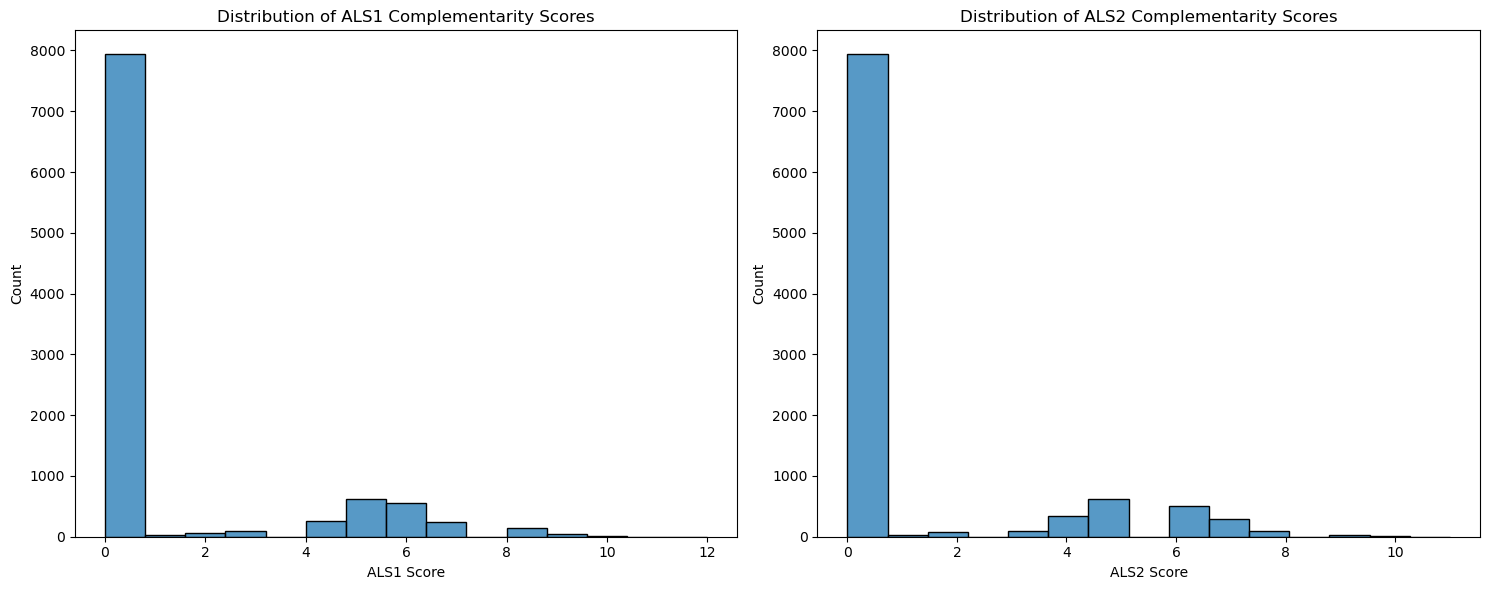

In [97]:
# Visualize ALS scores distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=enriched_overlaps_df, x='current_exon_als1_score', ax=ax1)
ax1.set_title('Distribution of ALS1 Complementarity Scores')
ax1.set_xlabel('ALS1 Score')

sns.histplot(data=enriched_overlaps_df, x='current_exon_als2_score', ax=ax2)
ax2.set_title('Distribution of ALS2 Complementarity Scores')
ax2.set_xlabel('ALS2 Score')

plt.tight_layout()
plt.show()

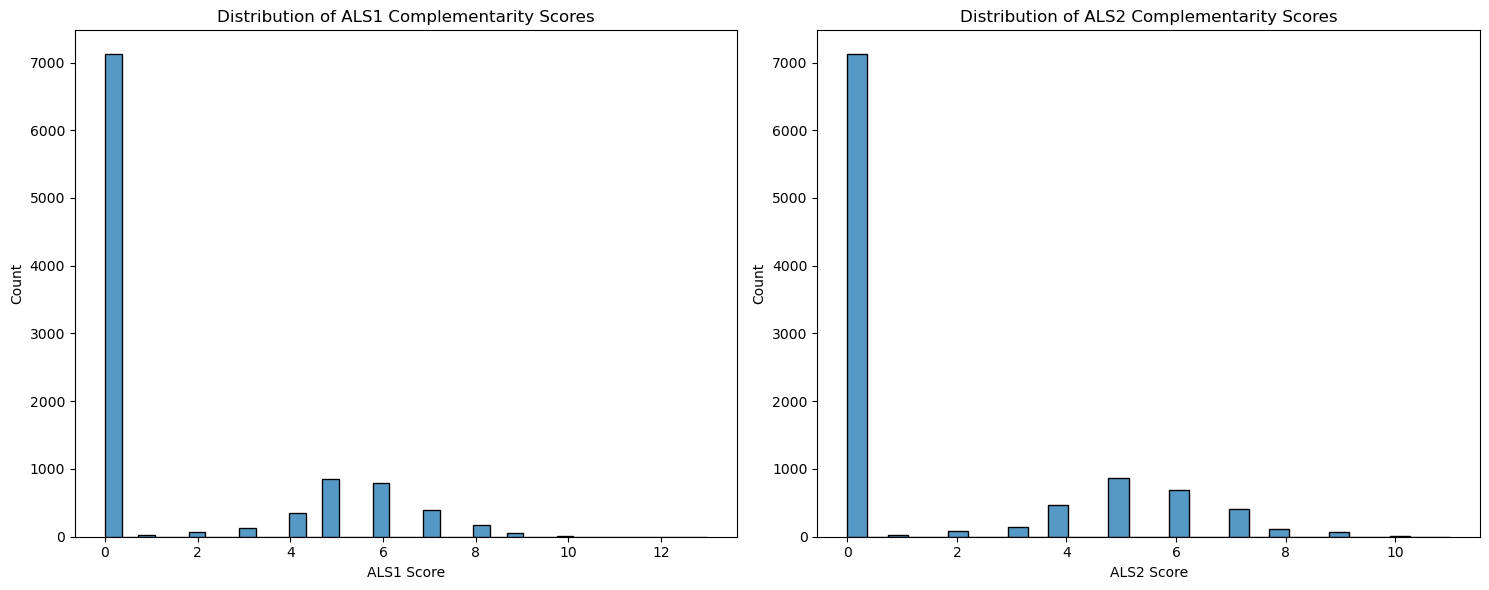

In [98]:
# Visualize ALS scores distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=enriched_overlaps_df2, x='current_exon_als1_score', ax=ax1)
ax1.set_title('Distribution of ALS1 Complementarity Scores')
ax1.set_xlabel('ALS1 Score')

sns.histplot(data=enriched_overlaps_df2, x='current_exon_als2_score', ax=ax2)
ax2.set_title('Distribution of ALS2 Complementarity Scores')
ax2.set_xlabel('ALS2 Score')

plt.tight_layout()
plt.show()

In [107]:
enriched_overlaps_df2["groupID"] = enriched_overlaps_df2["dexseq_name"].str.split(':').str[0]

In [108]:
enriched_overlaps_df2 = enriched_overlaps_df2.sort_values('current_exon_als1_score', ascending=False)

In [109]:
enriched_overlaps_df2.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_als1_score,current_exon_als2_score,neighboring_exons_analysis,groupID
2689,E001,622,chr3:149739286-149739508,ENSG00000114744.9:E001,chr3,-698.0,222.0,-0.053543,1.601783e-17,-0.6980,13.0,7.0,"{'E001': {'als1_score': 13.0, 'als2_score': 7....",ENSG00000114744.9
3553,E017,354,chr16:3685994-3686183,ENSG00000126602.11:E017,chr16,22.5,140.0,-0.204232,0.000000e+00,0.0225,11.0,5.0,"{'E016': {'als1_score': 5.0, 'als2_score': 5.0...",ENSG00000126602.11
7767,E014,664,chr11:7987375-7987572,ENSG00000175390.14:E014,chr11,-11425.0,0.0,-0.502531,2.176920e-190,-11.4250,11.0,9.0,"{'E014': {'als1_score': 11.0, 'als2_score': 9....",ENSG00000175390.14
149,E006,1084,chr12:6537674-6537919,ENSG00000010295.19:E006,chr12,-2267.5,0.0,-0.071574,0.000000e+00,-2.2675,10.0,8.0,"{'E005': {'als1_score': 1.0, 'als2_score': 1.0...",ENSG00000010295.19
5641,E019,333,chr13:98389956-98390143,ENSG00000152767.16:E019,chr13,-11436.0,0.0,0.000296,4.877803e-30,-11.4360,10.0,9.0,"{'E019': {'als1_score': 10.0, 'als2_score': 9....",ENSG00000152767.16


In [111]:
n_sel = 100 
sel_genes = enriched_overlaps_df2["groupID"][:n_sel]

In [112]:
import mygene

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
sel_genes_no_version = [id.split('.')[0] for id in sel_genes]

# Query the gene symbols
results = mg.querymany(sel_genes_no_version, scopes='ensembl.gene', fields='symbol', species='human')

# Create a dictionary mapping ENSEMBL IDs to symbols
gene_map = {res['query']: res.get('symbol', 'Not found') for res in results}

gene_symbols = [gene_map[ensembl_id.split('.')[0]] for ensembl_id in sel_genes]

ensembl_to_symbol = dict(zip(sel_genes, gene_symbols))

# # Print results
# for ensembl, symbol in ensembl_to_symbol.items():
#     print(f"{ensembl}: {symbol}")

18 input query terms found dup hits:	[('ENSG00000203930', 4), ('ENSG00000108424', 2), ('ENSG00000136010', 2), ('ENSG00000130741', 2), ('E


In [113]:
print(gene_symbols)

['COMMD2', 'TRAP1', 'EIF3F', 'IFFO1', 'FARP1', 'SLIT2', 'LINC00632', 'LINC00632', 'RLIM', 'KPNB1', 'OAT', 'BOLA1', 'ALDH1L2', 'NCAPG', 'KCND3', 'EIF2S3', 'CPSF4', 'RPRD2', 'CBX3', 'DIMT1', 'RANBP2', 'API5', 'STK26', 'SNAPIN', 'SNAPIN', 'NCAPD2', 'CNOT1', 'MTMR1', 'RPRD2', 'PCOLCE2', 'GPBP1', 'DDR2', 'CNOT1', 'DYNLL2', 'Not found', 'DDR2', 'DNASE1', 'GPBP1', 'OSBPL9', 'VCP', 'ETV3', 'MLEC', 'OSBPL9', 'PSIP1', 'TNIK', 'VOPP1', 'HEY1', 'METAP2', 'MTSS1', 'UBE2S', 'RPS28', 'GEMIN4', 'UBAP2L', 'RPL19', 'CDT1', 'CTNNB1', 'PRKDC', 'SFPQ', 'LRP1', 'QKI', 'QKI', 'HSPA4', 'IMPDH2', 'H2BC19P', 'SF3B3', 'H2BC19P', 'ACTG1', 'ARFIP2', 'SMC1A', 'ACTG1', 'EIF2S3', 'FBXO41', 'VCP', 'ALDH1L2', 'LINC00632', 'MAGED1', 'EIF4G2', 'EIF4G2', 'PTP4A2', 'UBAP2L', 'ANP32BP1', 'SEC23B', 'PTP4A2', 'PCM1', 'KPNB1', 'CECR2', 'NUP210', 'LINC00632', 'SNX6', 'STK26', 'PARP2', 'LATS1', 'WDR3', 'MOB1A', 'LYAR', 'REPS1', 'QKI', 'PRPF8', 'PBX1', 'RAB24']
